In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


main_dir = os.path.dirname(os.path.realpath('../__file__'))
dest_dir = os.path.join(main_dir, 'data', 'model', 'param_effect')

main_dir, dest_dir

if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

Error trying to connect to ACT-R at 127.0.0.1 : 2650 with exception (<class 'ConnectionRefusedError'>, ConnectionRefusedError(61, 'Connection refused'), <traceback object at 0x7fb27e8ab0c0>)
ACT-R connection NOT established, but no exception detected or already handled.
Could not start ACT-R connection.


In [2]:
def simulate_param_effect(model_name='markov-ibl-mb', param_name='temperature', e=5, save_output=False):
    # check exist 
    if save_output:
        f = os.path.join(save_output, '%s-%s-sim.csv' % (model_name, param_name))
        if os.path.exists(f):
            dff = pd.read_csv(f)
            return dff
    
    # start simulation
    r1, r0 = 1, 0
    params = {'REWARD': {'B1': (r1, r0), 'B2': (r1, r0), 'C1': (r1, r0), 'C2': (r1, r0)}, 
              'alpha': 0.2, 
              'beta': 5, 
              'beta_mf': 5, 
              'beta_mb': 5, 
              'lambda_parameter': 0.6, 
              'p_parameter': 0, 
              'temperature': 0.2, 
              'decay': 0.2, 
              'lf': 0.2, 
              'fixed_cost': 0.0, 
             }
    
    lower, upper = dict(zip(MarkovEstimation().param_names, MarkovEstimation().param_bounds))[param_name]
    param_values = np.linspace(lower, upper, num=5, endpoint=True).round(2)
    df_list = []
    for v in param_values:
        # update parameter
        params[param_name] = v
        df = MarkovSimulation.run_simulations(model=model_name, e=e, verbose=0, **params)
        df[param_name] = v
        df_list.append(df)
    dff = pd.concat(df_list, axis=0)
    
    # save simulation
    if save_output:
        f = os.path.join(save_output, '%s-%s-sim.csv' % (model_name, param_name))
        dff.to_csv(f, index=False)
    return dff

def plot_param_effect(df, model_name, param_name, combination=False):
    if combination:
        plot_param_effect_comb(df, model_name, param_name)
        return 
    g = sns.FacetGrid(df, col=param_name)
    g.map_dataframe(sns.pointplot, x=Plot.REWARD_FACTOR, y='state1_stay_mean',
                        hue=Plot.TRANS_FACTOR, errorbar='se',
                        palette=Plot.PALETTE,  
                        order=['reward', 'non-reward'],
                        hue_order=['common', 'rare']) 
    g.add_legend()
    g.refline(y=.5)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    g.fig.suptitle('PStay Effect of parameter [%s] on [%s]' %(param_name, model_name))
    
def plot_param_effect_comb(df, model_name, param_name):
    fig, ax = plt.subplots(figsize=(Plot.FIG_WIDTH, Plot.FIT_HEIGHT))
    fig.suptitle('Summary: PStay Effect of [%s] on [%s]' % (param_name, model_name))
    ax = sns.pointplot(data=df[df[Plot.TRANS_FACTOR]=='common'], 
                       x=Plot.REWARD_FACTOR, y='state1_stay_mean',
                       hue=param_name, 
                       palette='Blues',  
                       order=['reward', 'non-reward']) 
    ax = sns.pointplot(data=df[df[Plot.TRANS_FACTOR]=='rare'], 
                       x=Plot.REWARD_FACTOR, y='state1_stay_mean',
                       hue=param_name, 
                       palette='Reds',  
                       order=['reward', 'non-reward']) 
    ax.axhline(0.5, color='grey', ls='-.', linewidth=.5)
    plt.tight_layout()

def plot_param_effect_rt(df, model_name, param_name, combination=False):
    df['response_time_mean'] = df.apply(lambda x:x['state1_response_time_mean']+x['state2_response_time_mean'], axis=1)
    if combination:
        plot_param_effect_rt_comb(df, model_name, param_name)
        return 
    g = sns.FacetGrid(df, col=param_name)
    g.map_dataframe(sns.pointplot, x=Plot.REWARD_FACTOR, y='response_time_mean',
                        hue=Plot.TRANS_FACTOR, errorbar='se', dodge=True,
                        palette=Plot.PALETTE,  
                        order=['reward', 'non-reward'],
                        hue_order=['common', 'rare']) 
    g.add_legend()
    g.refline(y=1.09)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    g.fig.suptitle('RT Effect of parameter [%s] on [%s]' %(param_name, model_name))
    
def plot_param_effect_rt_comb(df, model_name, param_name):
    
    fig.suptitle('Summary: RT Effect of [%s] on [%s]' % (param_name, model_name))
    ax = sns.pointplot(data=df[df[Plot.TRANS_FACTOR]=='common'], 
                       x=Plot.REWARD_FACTOR, y='response_time_mean',
                       hue=param_name, dodge=.1, se='se',
                       palette='Blues',  
                       order=['reward', 'non-reward']) 
    ax = sns.pointplot(data=df[df[Plot.TRANS_FACTOR]=='rare'], 
                           x=Plot.REWARD_FACTOR, y='response_time_mean',
                           hue=param_name, dodge=.2,
                           palette='Reds',  
                           order=['reward', 'non-reward']) 
    ax.axhline(1.09, color='grey', ls='-.', linewidth=.5)
    plt.tight_layout()

## IBL-MB Model

### Effect of temperature (noise)

In [3]:
model_name = 'markov-ibl-mb'
param_name = 'temperature'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

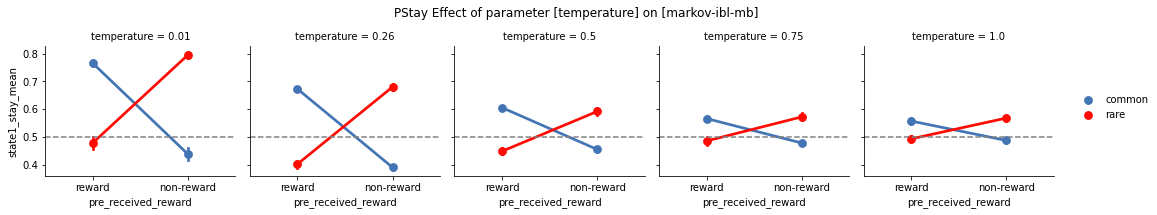

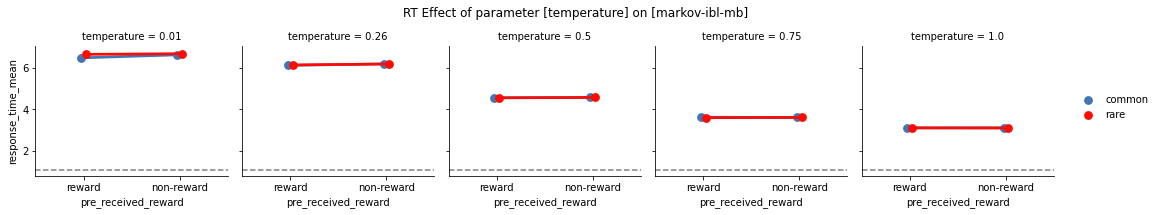

In [4]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of decay

In [5]:
model_name = 'markov-ibl-mb'
param_name = 'decay'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

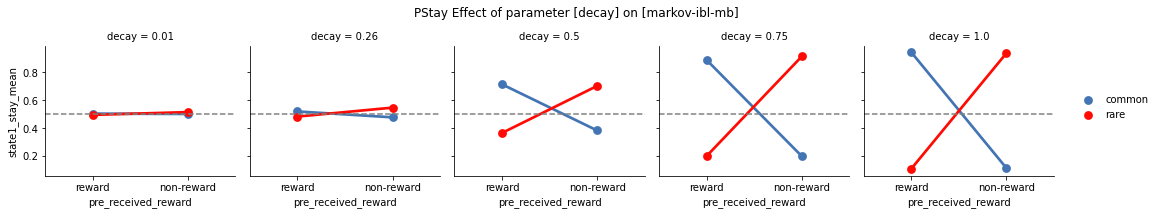

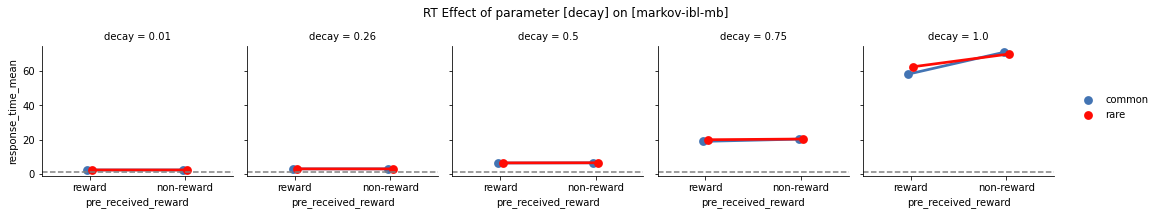

In [6]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of lf (latency factor)

In [7]:
model_name = 'markov-ibl-mb'
param_name = 'lf'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

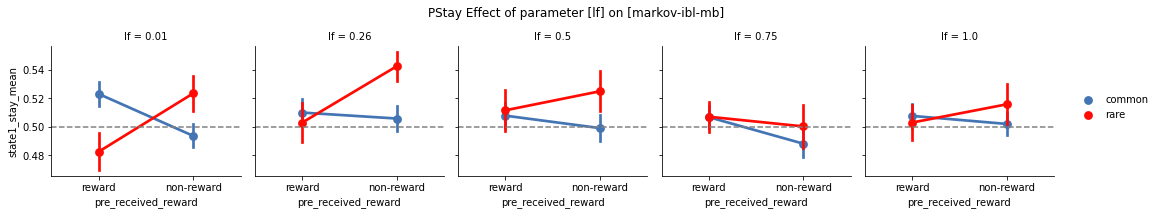

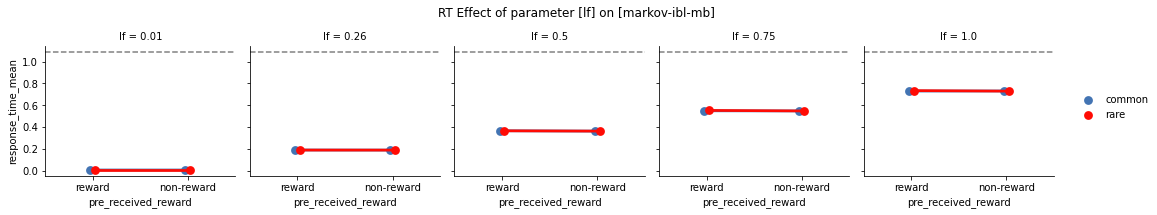

In [8]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of fixed_cost

In [9]:
model_name = 'markov-ibl-mb'
param_name = 'fixed_cost'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

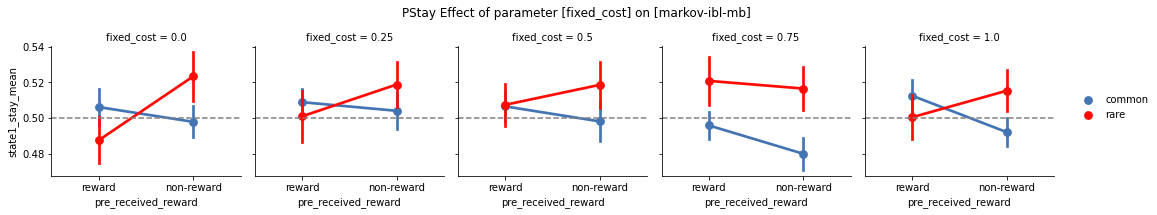

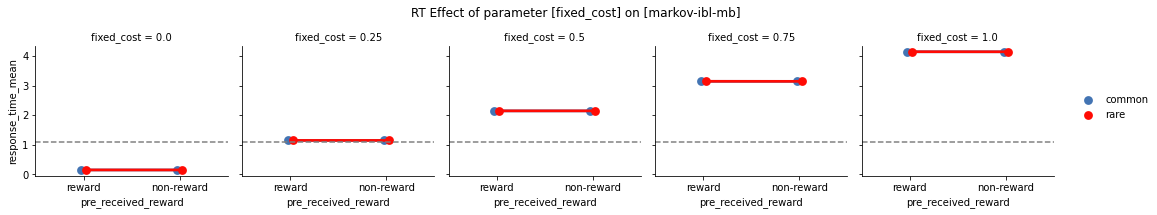

In [10]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

## IBL-Hybrid Model

### Effect of temperature (noise)

In [11]:
model_name = 'markov-ibl-hybrid'
param_name = 'temperature'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

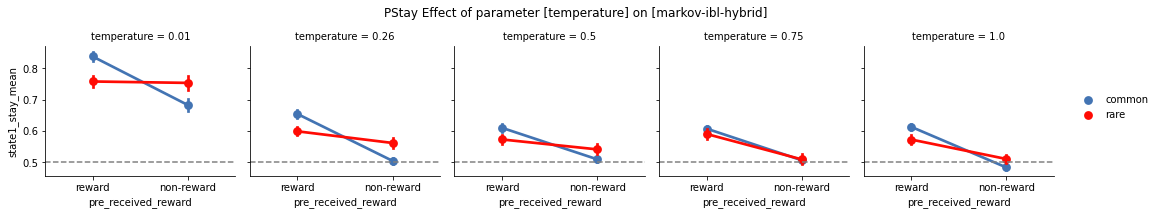

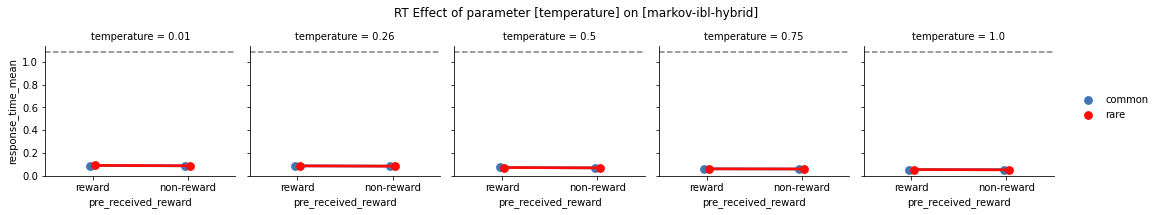

In [12]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of decay

In [13]:
model_name = 'markov-ibl-hybrid'
param_name = 'decay'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

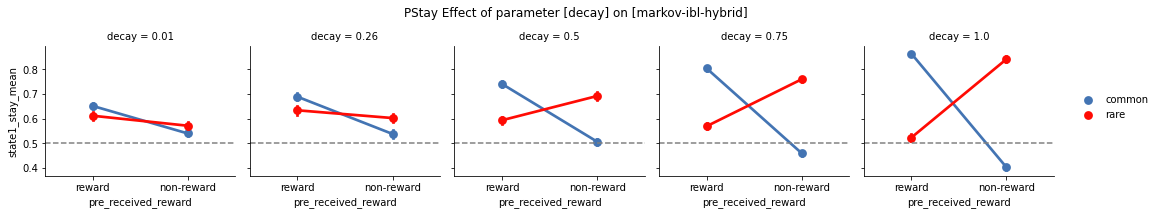

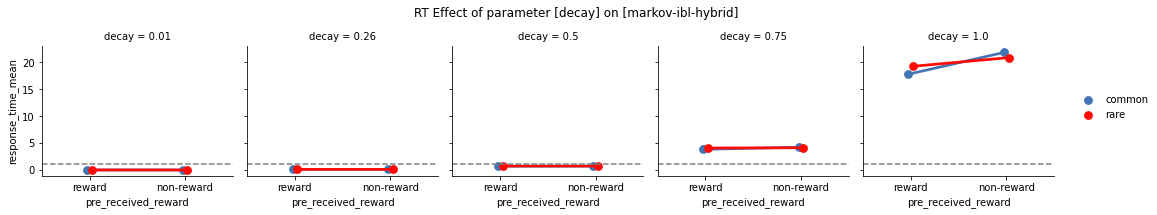

In [14]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of lf 

In [15]:
model_name = 'markov-ibl-hybrid'
param_name = 'lf'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

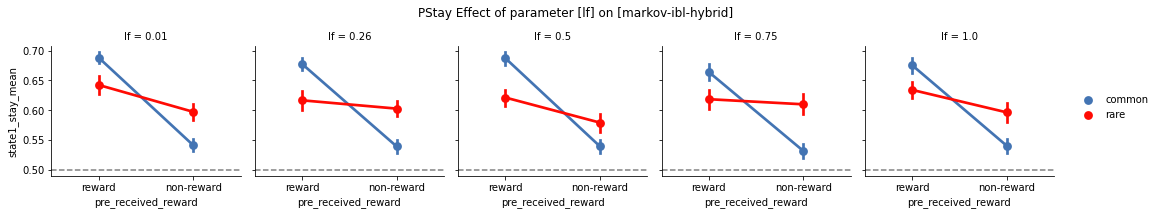

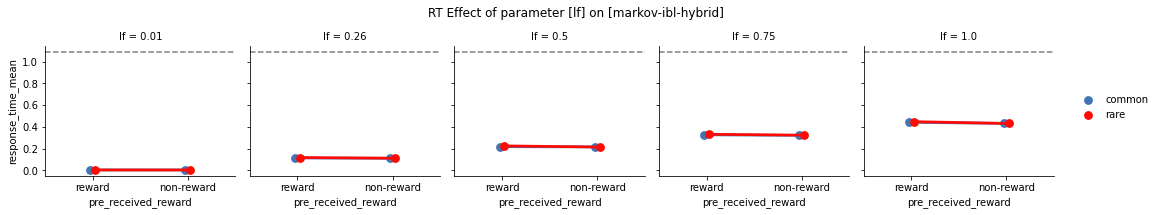

In [16]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of fixed_cost

In [17]:
model_name = 'markov-ibl-hybrid'
param_name = 'fixed_cost'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

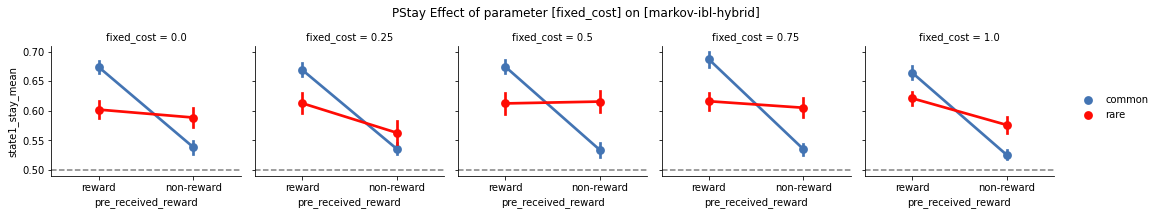

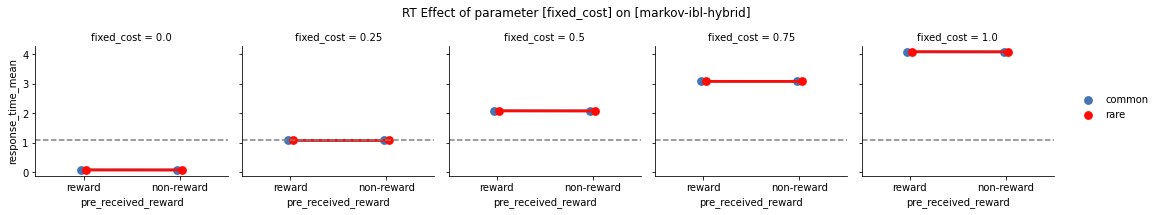

In [18]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

## RL-MF Model

### Effect of temperature (noise)

We should not observe any effect of noise nor decay on RL-MF model

In [19]:
model_name = 'markov-rl-mf'
param_name = 'decay'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

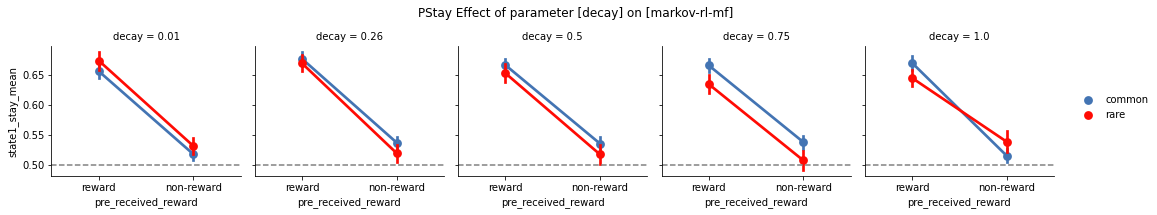

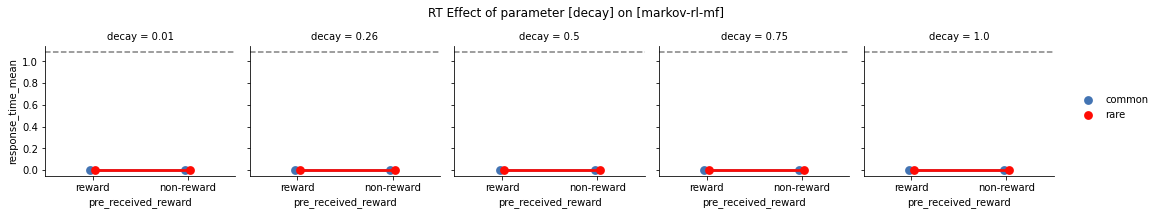

In [20]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

## RL-MF Model

### Effect of alpha 


In [21]:
model_name = 'markov-rl-mf'
param_name = 'alpha'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

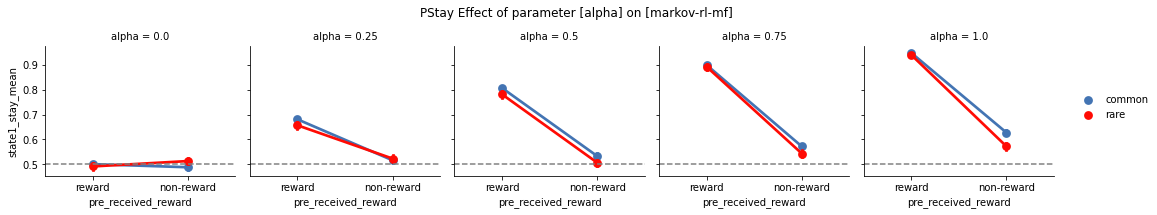

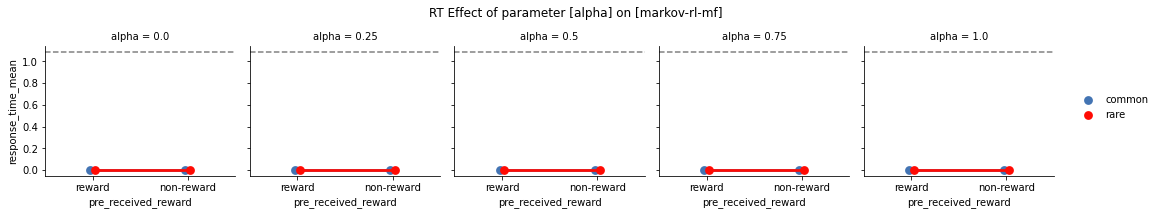

In [22]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of beta  

In [23]:
model_name = 'markov-rl-mf'
param_name = 'beta'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=False, e=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

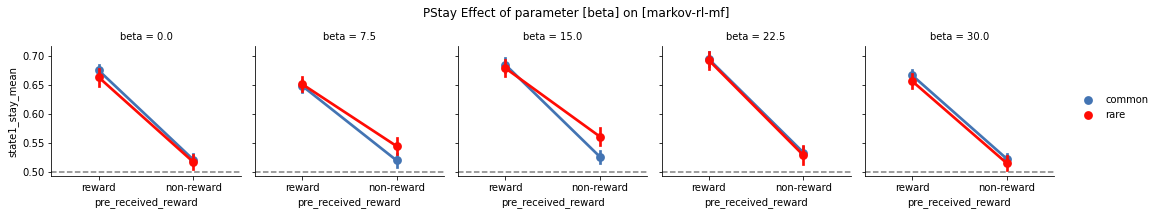

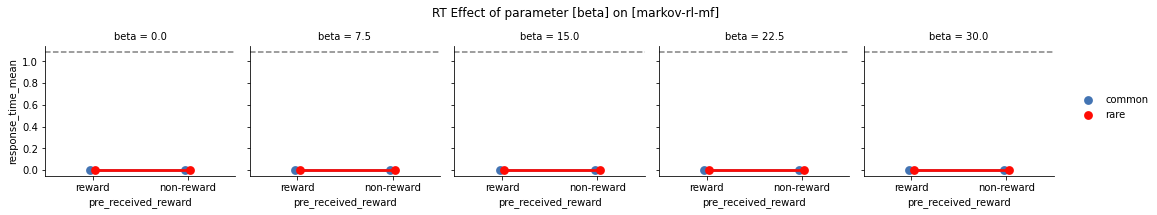

In [24]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of beta_mf

In [25]:
model_name = 'markov-rl-mf'
param_name = 'beta_mf'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

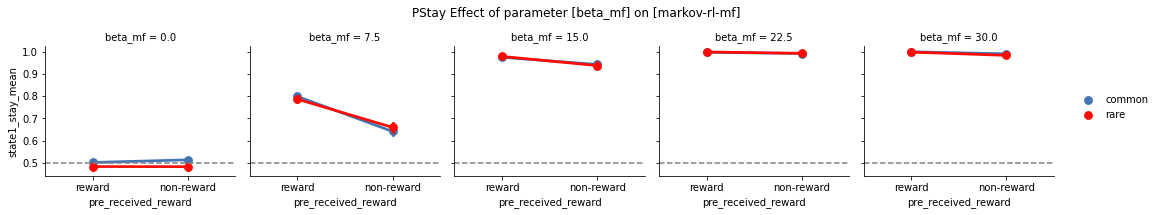

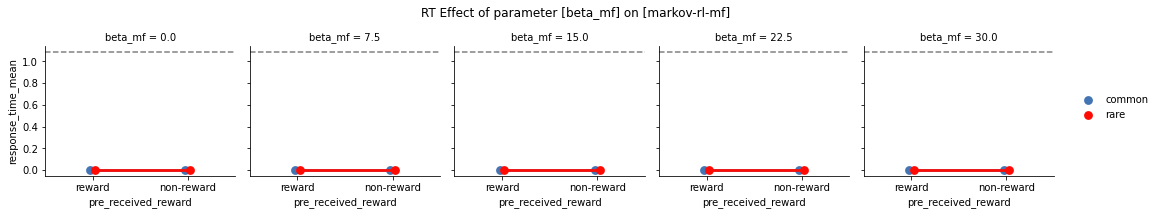

In [26]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

### Effect of beta_mb

In [27]:
model_name = 'markov-rl-mf'
param_name = 'beta_mb'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

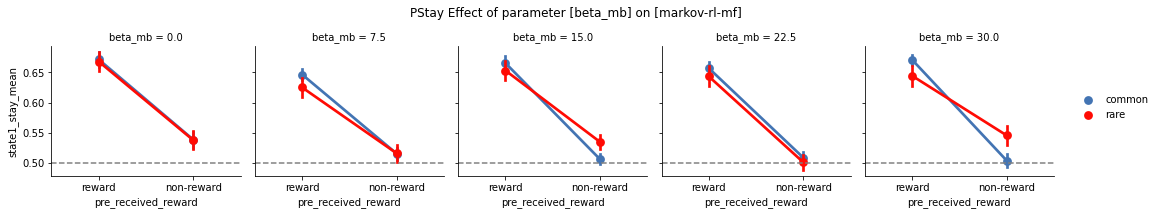

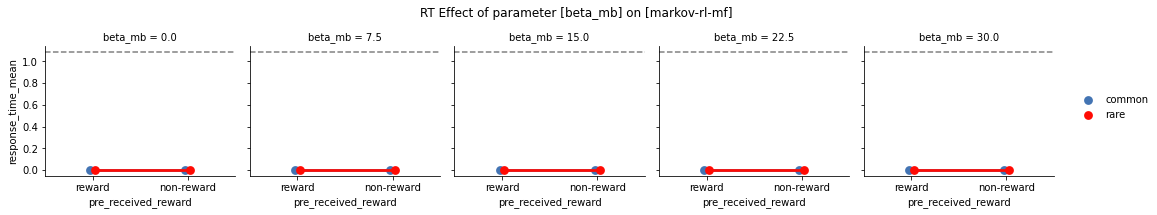

In [28]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

## RL-MF Model

### Effect of lambda 


In [29]:
model_name = 'markov-rl-mf'
param_name = 'lambda_parameter'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

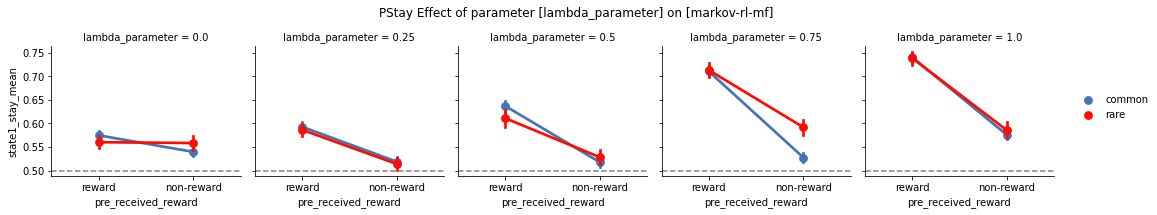

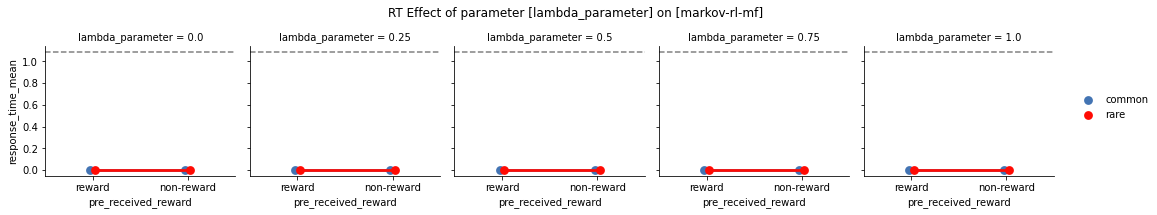

In [30]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)

## RL-MF Model

### Effect of stickness (p) 


In [31]:
model_name = 'markov-rl-mf'
param_name = 'p_parameter'
df = simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)

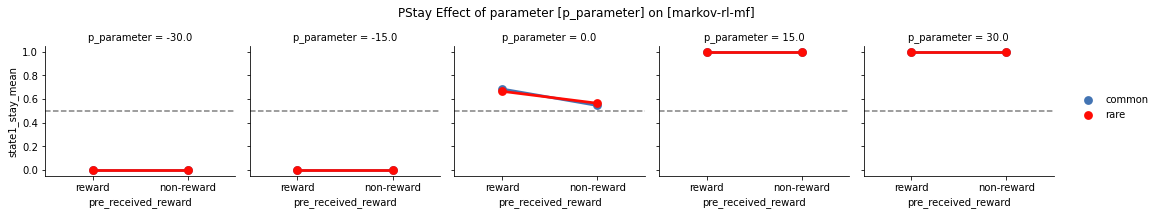

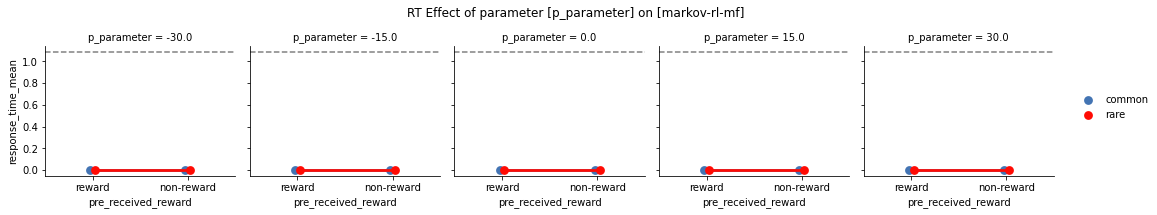

In [32]:
plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=False)
plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)
# plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)